# EMG Processing with PyCGM2

Here is an example of emg processing of gait trials through pyCGM2 code. 

**The context is to get emg signals stored in the c3d**.



In [13]:
import matplotlib.pyplot as plt

import pyCGM2

from pyCGM2.Tools import btkTools,trialTools
from pyCGM2.Signal import signal_processing

from pyCGM2.EMG import emgFilters,coactivation

from pyCGM2.Processing import cycle,analysis,c3dManager
from pyCGM2 import enums
from pyCGM2.Report import plot,plotFilters,emgPlotViewers




In this example, emg signals are labelled EMG1,EMG2, EMG3 and EMG4.

In [14]:
DATA_PATH = "C:\\Users\\HLS501\\Documents\\VICON DATA\\pyCGM2-Data\\EMG\\SampleNantes\\"
gaitTrial = "gait.c3d"
restTrial = "repos.c3d"

EMG_LABELS=['EMG1','EMG2','EMG3','EMG4']

acq = btkTools.smartReader(DATA_PATH +gaitTrial) # Acquisition Object from the Biomechanical toolkit)

## PROCESSING

### stage 1 - High pass filtering

At the end of this stage you can access both rectified and high-pass filtered EMG

In [15]:
bf = emgFilters.BasicEmgProcessingFilter(acq,EMG_LABELS)
bf.setHighPassFrequencies(20.0,200.0)
bf.run()

values = acq.GetAnalog("EMG1_Rectify").GetValues() #
values = acq.GetAnalog("EMG1_HPF").GetValues()

### stage 2 : calculate envelop


In [16]:
envf = emgFilters.EmgEnvelopProcessingFilter(acq,EMG_LABELS)
envf.setCutoffFrequency(180.0)
envf.run()

values = acq.GetAnalog("EMG1_Rectify_Env").GetValues() #


### Stage 3 :  save you acquisition 

you cam either overwrite or create a new c3d

In [17]:
btkTools.smartWriter(acq,DATA_PATH+"gait-emgProcessing.c3d")

### Stage 4 : Construction of an Analysis pyCGM2 instance





In [18]:


modelledFilenames = ["gait-emgProcessing.c3d"]

c3dmanagerProcedure = c3dManager.UniqueC3dSetProcedure(DATA_PATH,modelledFilenames)
cmf = c3dManager.C3dManagerFilter(c3dmanagerProcedure)
cmf.enableSpatioTemporal(False)
cmf.enableKinematic(False)
cmf.enableKinetic(False)
cmf.enableEmg(True)
trialManager = cmf.generate()


#---- GAIT CYCLES FILTER
#--------------------------------------------------------------------------
cycleBuilder = cycle.GaitCyclesBuilder(spatioTemporalTrials=trialManager.spatioTemporal["Trials"],
                                       kinematicTrials = trialManager.kinematic["Trials"],
                                       kineticTrials = trialManager.kinetic["Trials"],
                                       emgTrials=trialManager.emg["Trials"])

cyclefilter = cycle.CyclesFilter()
cyclefilter.setBuilder(cycleBuilder)
cycles = cyclefilter.build()


modelInfo=None
subjectInfo=None
experimentalInfo=None

analysisBuilder = analysis.GaitAnalysisBuilder(cycles,
                                              kinematicLabelsDict = None,
                                              kineticLabelsDict = None,
                                              emgLabelList = ['EMG1_Rectify_Env','EMG2_Rectify_Env','EMG3_Rectify_Env','EMG4_Rectify_Env'],
                                              subjectInfos=subjectInfo,
                                              modelInfos=modelInfo,
                                              experimentalInfos=experimentalInfo)

analysisFilter = analysis.AnalysisFilter()
analysisFilter.setBuilder(analysisBuilder)
analysisFilter.setInfo(model = modelInfo)
analysisFilter.build()

analysisInstance = analysisFilter.analysis


### stage 5  : Emg amplitude Normalisation

you must repeat the pyCGM2 filter for each emg signal while specifying the cycle context (Left or right)   

In [19]:

envnf = emgFilters.EmgNormalisationProcessingFilter(analysisInstance,"EMG1","Left")
envnf.setMaxMethod(enums.EmgAmplitudeNormalization.MeanMax)
envnf.run()

envnf = emgFilters.EmgNormalisationProcessingFilter(analysisInstance,"EMG2","Right")
envnf.setMaxMethod(enums.EmgAmplitudeNormalization.MeanMax)
envnf.run()

envnf = emgFilters.EmgNormalisationProcessingFilter(analysisInstance,"EMG3","Left")
envnf.setMaxMethod(enums.EmgAmplitudeNormalization.MeanMax)
envnf.run()


envnf = emgFilters.EmgNormalisationProcessingFilter(analysisInstance,"EMG4","Right")
envnf.setMaxMethod(enums.EmgAmplitudeNormalization.MeanMax)
envnf.run()


### stage 6 : Coactivation index

below , CA index from Unithan

In [20]:
cap = coactivation.UnithanCoActivationProcedure()
caf = emgFilters.EmgCoActivationFilter(analysisInstance,"Left")
caf.setEMG1("EMG1")
caf.setEMG2("EMG3")
caf.setCoactivationMethod(cap)
caf.run()

## Plot

### Temporal Emg

This plot displays either *Rectify* or *High pass* emg signal. In addition, gait normal activation area , defined in accordance with REF are displayed. 

For instance, the first graph displays EMG 1 and put normal activation of the rectus femoris in overlay 


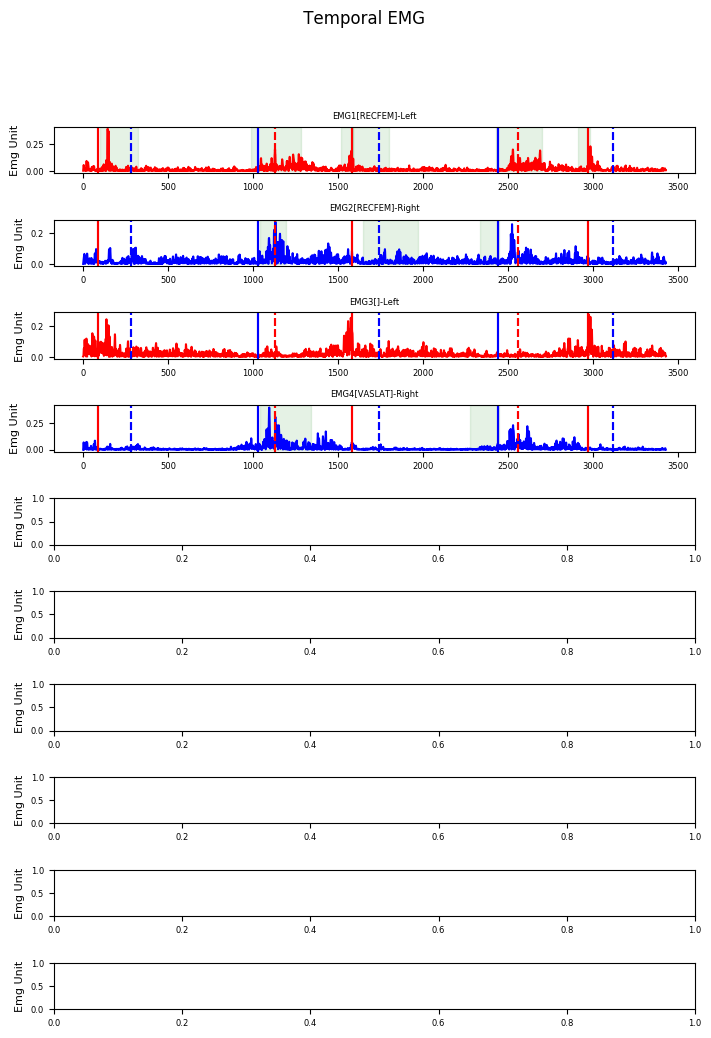

In [21]:
trial =trialTools.smartTrialReader(DATA_PATH,"gait-emgProcessing.c3d")

# # viewer
kv = emgPlotViewers.TemporalEmgPlotViewer(trial)
kv.setEmgs([["EMG1","Left"],["EMG2","Right"],["EMG3","Left"],["EMG4","Right"]])
kv.setNormalActivationLabels(["RECFEM","RECFEM",None,"VASLAT"])
kv. setEmgRectify(True)

# # filter
pf = plotFilters.PlottingFilter()
pf.setViewer(kv)
pf.plot()

plt.show()

### Emg Envelops

This plot panel allows displaying of 12 emg envelops. Similarly to temporal emg, normal activation are also displayed.  

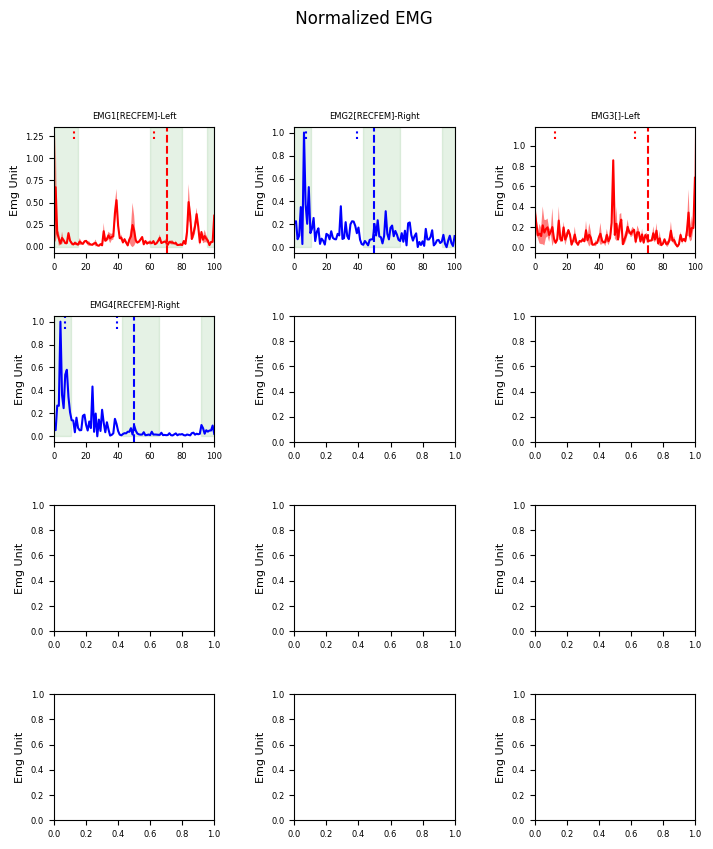

In [22]:
# viewer
kv = emgPlotViewers.EnvEmgGaitPlotPanelViewer (analysisInstance)
kv.setEmgs([["EMG1","Left"],["EMG2","Right"], ["EMG3","Left"], ["EMG4","Right"]])
kv.setNormalActivationLabels(["RECFEM","RECFEM",None,"RECFEM"])
kv.setConcretePlotFunction(plot.gaitDescriptivePlot)


# # filter
pf = plotFilters.PlottingFilter()
pf.setViewer(kv)
pf.plot()

plt.show()

### Coactivation plot

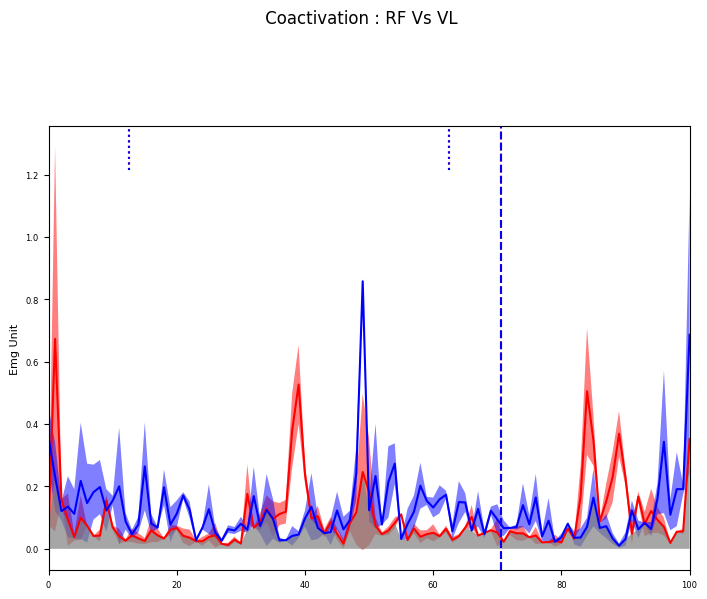

In [23]:
# viewer
kv = emgPlotViewers.CoactivationEmgPlotViewer (analysisInstance)
kv.setEmgs("EMG1","EMG3")
kv.setMuscles("RF","VL")
kv.setConcretePlotFunction(plot.gaitDescriptivePlot)
kv.setContext("Left")

# # filter
pf = plotFilters.PlottingFilter()
pf.setViewer(kv)
pf.plot()

plt.show()